# Synthetic Data Generation Strategy 4: Upsampling KEGG Pathways and sampling from a random normals multiplied by components of the SVD of our data. 


## Outline:

1.  Get means/variances from empirical data
2.  Use SVD trick from Ludwig to sample new 'regular' points.
3.  Get pathway information from KEGG database
4.  Resample the means for nodes in the pathway ("dysregulate" a subset of those nodes)
5.  Use SVD trick to sample new 'dysregulated' points.

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import pickle as pkl

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


# 1. Get means and variances of empirical data

Let's use the Ovarian cancer data since it's nicely compact. We'll use the Experimental InBioMap PPI. 

In [2]:
ovarian = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/ovarian_inbiomap_exp.tsv', index_col=0)

ovarian.head()

,ZNF91,NDEL1,ELAVL1,SUMO1,SUMO3,CHMP5,UBC,HTT,E2F4,ACP5,...,SPANXN4,ZNF605,SERPINB10,ANKAR,RRH,DHH,CYSLTR1,ZNF268,COL23A1,MEDAG
PNNL-TCGA-09-1664,0.0,-0.119,-0.1880,0.5710,-0.224000,0.3320,0.0,-0.2160,0.205,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1484,0.0,0.000,-0.1210,-1.4500,0.079000,0.1030,0.0,-0.9750,0.000,0.175,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1488,0.0,0.000,-0.2190,-0.0765,-1.340000,-0.4200,0.0,0.0158,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1489,0.0,0.000,0.2360,0.7490,0.107000,-0.0168,0.0,-0.1470,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1494,0.0,0.433,0.0158,-0.2100,0.000859,-0.5270,0.0,0.0926,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
means = ovarian.mean(axis=0)
variances = ovarian.var(axis=0)

# 2. Sample negative examples

## 2.1 Apply a standard scaling to our data (subtract by the means, divide by std-dev)

In [4]:
# ovarian = pd.DataFrame(StandardScaler().fit_transform(ovarian), columns=ovarian.columns, index=ovarian.index).astype(np.float32)
# ovarian.head()

## 2.2 Ludwig's Covariance Sampler

In [5]:
# data is n x d, where n is the number of samples and d the dimension
def sample_cov(m, data):
    n, d = data.shape
    mean = np.mean(data, axis=0)
    _, S, V = np.linalg.svd((data - mean) / math.sqrt(n), full_matrices=False)
    randomness = np.random.randn(m, min(n, d))
    return np.dot(randomness, np.dot(np.diag(S), V))

## 2.3 Sample from the same distribution as the input (we call these "negatives")

In [6]:
negatives = sample_cov(100, ovarian)
negatives = np.around(negatives + means.values, 6)
negatives = pd.DataFrame(negatives, columns=ovarian.columns, index=['negative']*100)
negatives.head()

,ZNF91,NDEL1,ELAVL1,SUMO1,SUMO3,CHMP5,UBC,HTT,E2F4,ACP5,...,SPANXN4,ZNF605,SERPINB10,ANKAR,RRH,DHH,CYSLTR1,ZNF268,COL23A1,MEDAG
negative,-0.0,-0.340342,0.086941,0.704513,1.016886,0.435370,0.0,-0.714178,0.286918,-0.008855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,-0.072958,-0.136913,0.750814,0.347315,0.037808,-0.0,-0.295412,-0.164848,-0.138569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,0.111395,0.066380,-0.421866,-0.589742,-0.306874,0.0,-0.415386,0.441566,-0.600572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,0.119310,-0.007721,0.045142,-0.616843,0.128891,-0.0,0.143808,0.090841,0.504894,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,-0.189842,-0.191221,0.255840,0.141932,0.082622,0.0,-0.184334,-0.012335,-0.194049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3. Retrieve KEGG pathways

(pathways found at http://rest.kegg.jp/list/pathway/hsa)

In [8]:
pathways = pkl.load(open("/Users/alex/Documents/proteomics/synthetic_proteomics/data_generation/old_KEGG_pathway_gene_lists.pkl", "rb"))
pathway_id = "hsa00830"
pathway_genes = np.array(pathways[pathway_id])
pathway_genes

array(['BCO1', 'ADH1A', 'ADH1B', 'ADH1C', 'ADH7', 'ADH4', 'ADH5', 'ADH6',
       'DHRS3', 'DHRS4', 'DHRS4L1', 'DHRS4L2', 'DHRS9', 'RDH8', 'RDH10',
       'RDH11', 'RDH12', 'RDH16', 'SDR16C5', 'HSD17B6', 'LRAT', 'DGAT1',
       'AWAT2', 'PNPLA4', 'RPE65', 'RDH5', 'AOX1', 'ALDH1A2', 'ALDH1A1',
       'CYP26A1', 'CYP26B1', 'CYP26C1', 'CYP1A1', 'CYP1A2', 'CYP2A6',
       'CYP2B6', 'CYP2C8', 'CYP2C9', 'CYP2C18', 'CYP2S1', 'CYP3A4',
       'CYP3A5', 'CYP3A7', 'CYP3A7-CYP3A51P', 'CYP4A11', 'UGT2A1',
       'UGT2A3', 'UGT2B17', 'UGT2B11', 'UGT2B28', 'UGT1A6', 'UGT1A4',
       'UGT1A1', 'UGT1A3', 'UGT2B10', 'UGT1A9', 'UGT2B7', 'UGT1A10',
       'UGT1A8', 'UGT1A5', 'UGT2B15', 'UGT1A7', 'UGT2B4', 'UGT2A2',
       'RETSAT'],
      dtype='<U15')

# 4. Update the pathway means by resampling.

In [9]:
new_pathway_means = pd.Series(np.random.normal(0,variances), index=variances.index)[pathway_genes].fillna(0)
new_means = pd.concat([means, new_pathway_means], axis=1).fillna(0).sum(axis=1).reindex(means.index)
new_means.head()

ZNF91     0.000000
NDEL1     0.010325
ELAVL1    0.031412
SUMO1     0.126737
SUMO3    -0.039357
dtype: float64

# 5. Sample positive examples

In [10]:
positives = sample_cov(100, ovarian)
positives = np.around(positives + new_means.values, 6)
positives = pd.DataFrame(positives, columns=ovarian.columns, index=[pathway_id]*100)
positives.head()

,ZNF91,NDEL1,ELAVL1,SUMO1,SUMO3,CHMP5,UBC,HTT,E2F4,ACP5,...,SPANXN4,ZNF605,SERPINB10,ANKAR,RRH,DHH,CYSLTR1,ZNF268,COL23A1,MEDAG
hsa00830,0.0,-0.174994,-0.016008,0.578854,-0.883803,0.034943,0.0,0.474227,0.254888,-0.589186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa00830,-0.0,0.177888,-0.182600,0.067403,0.453411,-0.241085,-0.0,-0.237875,0.294950,-0.279966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa00830,0.0,-0.313275,0.334003,0.019009,0.513477,0.533990,-0.0,0.012134,0.956460,-0.027019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa00830,0.0,-0.055120,0.014046,-0.376788,-0.167616,0.363692,0.0,-0.364498,0.305706,0.404443,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa00830,-0.0,-0.704375,0.204562,0.384501,-0.445709,-0.362991,0.0,-1.061112,-0.086533,-0.404047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
ovarian = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/ovarian_inbiomap_exp.tsv', index_col=0)
ovarian.index = ['true'] * len(ovarian)

In [13]:
dataset = pd.concat([ovarian, positives, negatives])
y = dataset.index.values

PC 1: 9.35%   PC 2: 4.26%   


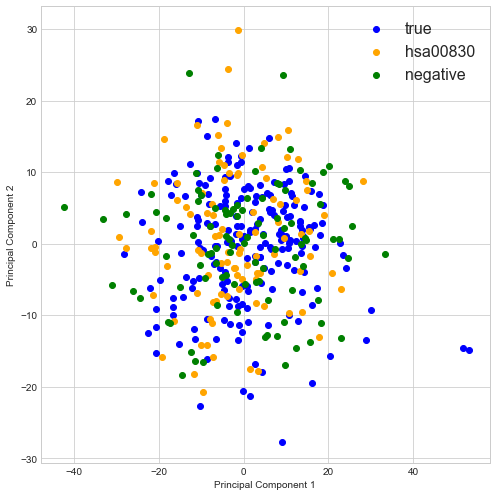

In [14]:
pca = PCA(n_components=2)
Y = pca.fit_transform(dataset)

with plt.style.context('seaborn-whitegrid'):
    figure(figsize=(7, 7))
    for label, color in zip(('true','hsa00830', 'negative'), ('blue','orange', 'green')):
        plt.scatter(Y[y==label, 0], Y[y==label, 1], label=label, c=color)
        
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='upper right',prop={'size':16})
    plt.tight_layout()
    print(''.join(['PC '+str(i+1)+': '+str(var*100)[:4]+'%   ' for i, var in enumerate(pca.explained_variance_ratio_)]))
    plt.show()

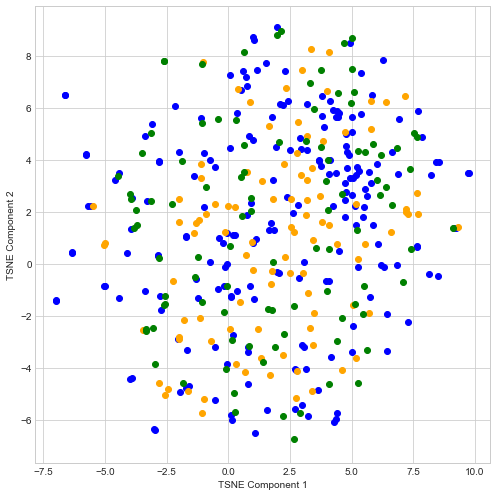

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(learning_rate=100, perplexity=20)
Y = tsne.fit_transform(dataset)

with plt.style.context('seaborn-whitegrid'):
    figure(figsize=(7, 7))
    for label, color in zip(('true','hsa00830', 'negative'), ('blue','orange', 'green')):
        plt.scatter(Y[y==label, 0], Y[y==label, 1], label=label, c=color)
        
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
#     plt.legend(loc='upper right',prop={'size':16})
    plt.tight_layout()
    plt.show()